In [1]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
import warnings
import random

warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


T = 160
delta = 4
Delta = 8
Gamma = 30
channels = ['Oz..', 'T7..', 'Cz..']


In [2]:
def process_edf(file_path, channels, T=160, delta=4, Delta=8, Gamma=30):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick(channels)
    data = raw.get_data().T.astype(np.float32)
    
    # Normalize the data.
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data).astype(np.float32)
    
    n_samples = normalized_data.shape[0]
    windows = [normalized_data[start:start+T, :] 
               for start in range(0, n_samples - T + 1, delta)]
    windows = np.array(windows, dtype=np.float32)
    
    # Create augmented samples by grouping Gamma consecutive windows with a step of Delta.
    augmented = [windows[i:i+Gamma] 
                 for i in range(0, len(windows) - Gamma + 1, Delta)]
    augmented = np.array(augmented, dtype=np.float32)
    
    return augmented


In [4]:
class PhysionetAugmentedDataset(Dataset):
    def __init__(self, subject_ids, channels, T=160, delta=4, Delta=8, Gamma=30):
        self.subject_ids = subject_ids
        self.channels = channels
        self.T = T
        self.delta = delta
        self.Delta = Delta
        self.Gamma = Gamma
        self.indices = []
        
        for label, subject in enumerate(tqdm(subject_ids, desc="Building index")):
            for r in range(1, 3):
                file_path = f'./files/S{subject:03d}/S{subject:03d}R{r:02d}.edf'
                try:
                    augmented = process_edf(file_path, channels, T, delta, Delta, Gamma)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue
                num_augmented = augmented.shape[0]
                for aug_idx in range(num_augmented):
                    self.indices.append((subject, r, aug_idx, file_path, label))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        subject, r, aug_idx, file_path, label = self.indices[idx]
        augmented = process_edf(file_path, self.channels, self.T, self.delta, self.Delta, self.Gamma)
        sample = augmented[aug_idx]
        sample_tensor = torch.tensor(sample, dtype=torch.float32)
        return sample_tensor, label
    
subjects = list(range(1, 91))
dataset = PhysionetAugmentedDataset(subjects, channels, T, delta, Delta, Gamma)


Building index: 100%|██████████| 90/90 [00:03<00:00, 24.65it/s]


In [5]:

all_indices = list(range(len(dataset)))
labels = [dataset.indices[i][-1] for i in all_indices]  

# Perform a stratified split (80% train, 20% test)
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=labels, random_state=42)

# Create subset datasets using the indices.
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders for both splits.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(1,2))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(153600, 1024)
        self.dense2 = nn.Linear(1024, 90)
        self.dropout = nn.Dropout2d(0.5) #hyperparameter

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)

        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)
        
        x = self.flatten(x)

        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x
    
model = CNN().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(batch_labels.cpu().numpy())
    
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Train Accuracy = {train_accuracy:.4f}")

Epoch 1/20: 100%|██████████| 1337/1337 [10:24<00:00,  2.14it/s]


Epoch 1: Loss = 3.1483, Train Accuracy = 0.2208


Epoch 2/20: 100%|██████████| 1337/1337 [10:27<00:00,  2.13it/s]


Epoch 2: Loss = 1.9222, Train Accuracy = 0.4624


Epoch 3/20: 100%|██████████| 1337/1337 [10:34<00:00,  2.11it/s]


Epoch 3: Loss = 1.3679, Train Accuracy = 0.5950


Epoch 4/20: 100%|██████████| 1337/1337 [10:38<00:00,  2.09it/s]


Epoch 4: Loss = 1.0002, Train Accuracy = 0.6919


Epoch 5/20: 100%|██████████| 1337/1337 [10:43<00:00,  2.08it/s]


Epoch 5: Loss = 0.7759, Train Accuracy = 0.7559


Epoch 6/20: 100%|██████████| 1337/1337 [10:47<00:00,  2.07it/s]


Epoch 6: Loss = 0.6005, Train Accuracy = 0.8081


Epoch 7/20: 100%|██████████| 1337/1337 [10:34<00:00,  2.11it/s]


Epoch 7: Loss = 0.4962, Train Accuracy = 0.8393


Epoch 8/20: 100%|██████████| 1337/1337 [10:28<00:00,  2.13it/s]


Epoch 8: Loss = 0.4060, Train Accuracy = 0.8676


Epoch 9/20: 100%|██████████| 1337/1337 [10:34<00:00,  2.11it/s]


Epoch 9: Loss = 0.3328, Train Accuracy = 0.8914


Epoch 10/20: 100%|██████████| 1337/1337 [10:40<00:00,  2.09it/s]


Epoch 10: Loss = 0.2867, Train Accuracy = 0.9045


Epoch 11/20: 100%|██████████| 1337/1337 [10:37<00:00,  2.10it/s]


Epoch 11: Loss = 0.2442, Train Accuracy = 0.9189


Epoch 12/20: 100%|██████████| 1337/1337 [10:41<00:00,  2.09it/s]


Epoch 12: Loss = 0.2089, Train Accuracy = 0.9310


Epoch 13/20: 100%|██████████| 1337/1337 [10:46<00:00,  2.07it/s]


Epoch 13: Loss = 0.2024, Train Accuracy = 0.9325


Epoch 14/20: 100%|██████████| 1337/1337 [10:46<00:00,  2.07it/s]


Epoch 14: Loss = 0.1558, Train Accuracy = 0.9491


Epoch 15/20: 100%|██████████| 1337/1337 [10:32<00:00,  2.11it/s]


Epoch 15: Loss = 0.1496, Train Accuracy = 0.9513


Epoch 16/20: 100%|██████████| 1337/1337 [10:32<00:00,  2.11it/s]


Epoch 16: Loss = 0.1404, Train Accuracy = 0.9549


Epoch 17/20: 100%|██████████| 1337/1337 [10:37<00:00,  2.10it/s]


Epoch 17: Loss = 0.1211, Train Accuracy = 0.9593


Epoch 18/20: 100%|██████████| 1337/1337 [10:42<00:00,  2.08it/s]


Epoch 18: Loss = 0.1175, Train Accuracy = 0.9606


Epoch 19/20: 100%|██████████| 1337/1337 [10:42<00:00,  2.08it/s]


Epoch 19: Loss = 0.0932, Train Accuracy = 0.9702


Epoch 20/20: 100%|██████████| 1337/1337 [10:42<00:00,  2.08it/s]

Epoch 20: Loss = 0.0954, Train Accuracy = 0.9685


In [9]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved as model.pth")

Model saved as model.pth


In [10]:
model.eval()
all_test_preds = []
all_test_labels = []
with torch.no_grad():
    for batch_data, batch_labels in tqdm(test_loader, desc="Evaluating"):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_data)
        preds = outputs.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().numpy())
    
    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

Evaluating: 100%|██████████| 335/335 [02:29<00:00,  2.24it/s]

Epoch 20: Test Accuracy = 0.9461


In [4]:
model.load_state_dict(torch.load('./model.pth', map_location = device))
model.eval()

embedding_output = None
def hook_fn(module, input, output):
    global embedding_output
    embedding_output = output.detach()

hook_handle = model.dropout.register_forward_hook(hook_fn)

def get_embedding(sample):
    global embedding_output
    if sample.dim() == 3:
        sample = sample.unsqueeze(0)
    sample = sample.to(device)

    with torch.no_grad():
        _ = model(sample)

    emb = embedding_output.squeeze()
    if emb.ndim > 1:
        emb = emb.squeeze(0)

    norm = torch.norm(emb, p=2)
    if norm > 0:
        emb = emb / norm
    return emb.cpu().numpy()

In [5]:
def enroll_subjects(subject_data):
    subject_fingerprints = {}
    for subject_id, samples in subject_data.items():
        embeddings = []
        for sample in samples:
            emb = get_embedding(sample)  
            embeddings.append(emb)
        
        embeddings = np.vstack(embeddings)
        # Average the embeddings and normalize
        avg_embedding = np.mean(embeddings, axis=0)
        avg_embedding = avg_embedding / np.linalg.norm(avg_embedding)
        subject_fingerprints[subject_id] = avg_embedding
    return subject_fingerprints

In [6]:
def classify_sample(sample, subject_fingerprints, threshold=0.275):
    # Extract embedding from the sample
    if isinstance(sample, np.ndarray):
        emb = sample
    else:
        emb = get_embedding(sample)
    similarities = {}
    cosine_distances = {}
    
    # Compare against each enrolled fingerprint
    for subject, fingerprint in subject_fingerprints.items():
        similarity = cosine_similarity(emb.reshape(1, -1), fingerprint.reshape(1, -1))[0, 0]  # cosine similarity (embeddings are normalized)
        distance = 1 - similarity              # cosine distance
        similarities[subject] = similarity
        cosine_distances[subject] = distance
    
    # Determine the best match (subject with minimum cosine distance)
    best_subject = min(cosine_distances, key=cosine_distances.get)
    best_distance = cosine_distances[best_subject]
    
    # Apply threshold decision rule
    if best_distance < threshold:
        predicted_subject = best_subject
    else:
        predicted_subject = "unknown"  
    
    return predicted_subject, similarities, cosine_distances

In [8]:
subject_fingerprints = {}
enroll_ratio = 0.77

for subject in tqdm(range(91, 110)):
    fingerprints = []
    for run in [1, 2]:
        file_path = f'./files/S{subject:03d}/S{subject:03d}R{run:02d}.edf'
        try:
            augmented = process_edf(file_path, channels, T, delta, Delta, Gamma)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
        
        for i in range(augmented.shape[0]):
            sample = augmented[i]  
            sample_tensor = torch.tensor(sample, dtype=torch.float32)
            emb = get_embedding(sample_tensor)
            fingerprints.append(emb)
    
    if len(fingerprints) == 0:
        print(f"No valid embeddings for subject {subject}")
        continue
    
    fingerprints = np.stack(fingerprints, axis=0)
    num_samples = fingerprints.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    n_enroll = int(enroll_ratio * num_samples)
    enroll_indices = indices[:n_enroll]

    enroll_embedding = np.mean(fingerprints[enroll_indices], axis=0)
    enroll_embedding = enroll_embedding / np.linalg.norm(enroll_embedding)
    subject_fingerprints[subject] = enroll_embedding

print("Enrollment complete for subjects 90-109")

100%|██████████| 19/19 [00:15<00:00,  1.19it/s]

Enrollment complete for subjects 90-109


In [10]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch

enroll_ratio = 0.77  
threshold = 0.01  

auth_results = {}
correct = 0
total = 0
gt_labels = []
pred_labels = []
# Loop over subjects (for example, subjects 91 to 109)
for subject in tqdm(range(91, 110)):
    embeddings = []  
    
    # Process both runs (e.g. run 1 and run 2)
    for run in [1, 2]:
        file_path = f'./files/S{subject:03d}/S{subject:03d}R{run:02d}.edf'
        try:
            augmented = process_edf(file_path, channels, T, delta, Delta, Gamma)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

        # For each augmented sample, extract embedding using get_embedding
        for i in range(augmented.shape[0]):
            sample = augmented[i]  
            sample_tensor = torch.tensor(sample, dtype=torch.float32)
            emb = get_embedding(sample_tensor)
            embeddings.append(emb)
    
    if len(embeddings) == 0:
        print(f"No valid embeddings for subject {subject}")
        continue

    embeddings = np.stack(embeddings, axis=0)
    num_samples = embeddings.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    n_auth = num_samples - int(enroll_ratio * num_samples)
    auth_indices = indices[-n_auth:]
    # Compute authentication fingerprint from the remaining samples
    auth_embedding = np.mean(embeddings[auth_indices], axis=0)
    auth_embedding = auth_embedding / np.linalg.norm(auth_embedding)
    
    predicted_subject, sims, dists = classify_sample(auth_embedding, subject_fingerprints, threshold=threshold)
    print(f"Predicted Subject: {predicted_subject} Subject: {subject} Cosine Distances {dists}")
    auth_results[subject] = predicted_subject

    gt_labels.append(subject)
    pred_labels.append(predicted_subject)


  5%|▌         | 1/19 [00:00<00:17,  1.00it/s]

Predicted Subject: 91 Subject: 91 Cosine Distances {91: 0.005305230617523193, 92: 0.4263037443161011, 93: 0.677625834941864, 94: 0.5749056935310364, 95: 0.654430091381073, 96: 0.5921144485473633, 97: 0.5766628682613373, 98: 0.41082847118377686, 99: 0.32694756984710693, 100: 0.46795547008514404, 101: 0.5674752593040466, 102: 0.5158804953098297, 103: 0.6803399920463562, 104: 0.768812745809555, 105: 0.6636892259120941, 106: 0.634347677230835, 107: 0.6003037691116333, 108: 0.38943421840667725, 109: 0.6768599152565002}


 11%|█         | 2/19 [00:01<00:15,  1.09it/s]

Predicted Subject: 92 Subject: 92 Cosine Distances {91: 0.4280903935432434, 92: 0.0019060373306274414, 93: 0.45054781436920166, 94: 0.8014165759086609, 95: 0.411409854888916, 96: 0.486775279045105, 97: 0.5901725888252258, 98: 0.7426287829875946, 99: 0.31983935832977295, 100: 0.604591429233551, 101: 0.38030028343200684, 102: 0.29293131828308105, 103: 0.5098990201950073, 104: 0.7387980222702026, 105: 0.6713078022003174, 106: 0.4433645009994507, 107: 0.28582262992858887, 108: 0.3969604969024658, 109: 0.483206570148468}


 16%|█▌        | 3/19 [00:02<00:14,  1.08it/s]

Predicted Subject: 93 Subject: 93 Cosine Distances {91: 0.6836858689785004, 92: 0.45825397968292236, 93: 0.0026417970657348633, 94: 0.6507552564144135, 95: 0.36730194091796875, 96: 0.33175379037857056, 97: 0.3823254108428955, 98: 0.7677955329418182, 99: 0.5745556652545929, 100: 0.5475243926048279, 101: 0.2953755259513855, 102: 0.39548349380493164, 103: 0.28644275665283203, 104: 0.4329211711883545, 105: 0.35950911045074463, 106: 0.16073554754257202, 107: 0.44464969635009766, 108: 0.3180667757987976, 109: 0.17555630207061768}


 21%|██        | 4/19 [00:03<00:13,  1.11it/s]

Predicted Subject: 94 Subject: 94 Cosine Distances {91: 0.5798949301242828, 92: 0.7935900539159775, 93: 0.631330668926239, 94: 0.0014204978942871094, 95: 0.8436513692140579, 96: 0.8649151027202606, 97: 0.28205758333206177, 98: 0.23174142837524414, 99: 0.7228439450263977, 100: 0.3516104817390442, 101: 0.7927995175123215, 102: 0.8132176101207733, 103: 0.7519616335630417, 104: 0.36489439010620117, 105: 0.22007977962493896, 106: 0.5931612849235535, 107: 0.8988543897867203, 108: 0.6433379650115967, 109: 0.7575070559978485}


 26%|██▋       | 5/19 [00:04<00:12,  1.11it/s]

Predicted Subject: 95 Subject: 95 Cosine Distances {91: 0.6515096127986908, 92: 0.41322237253189087, 93: 0.37685179710388184, 94: 0.8422909677028656, 95: 0.0028668642044067383, 96: 0.38614678382873535, 97: 0.6551093459129333, 98: 0.8149702548980713, 99: 0.5233020782470703, 100: 0.7522580921649933, 101: 0.2794966697692871, 102: 0.5013578534126282, 103: 0.19424068927764893, 104: 0.5589216351509094, 105: 0.63935387134552, 106: 0.44270408153533936, 107: 0.28762584924697876, 108: 0.321053683757782, 109: 0.2789038419723511}


 32%|███▏      | 6/19 [00:05<00:11,  1.11it/s]

Predicted Subject: 96 Subject: 96 Cosine Distances {91: 0.6003127098083496, 92: 0.48969894647598267, 93: 0.3294827342033386, 94: 0.8715324103832245, 95: 0.3545200824737549, 96: 0.0032283663749694824, 97: 0.6845756769180298, 98: 0.8394320607185364, 99: 0.5554501116275787, 100: 0.7528156638145447, 101: 0.27837347984313965, 102: 0.4756341576576233, 103: 0.36563897132873535, 104: 0.7281265556812286, 105: 0.719622015953064, 106: 0.411038875579834, 107: 0.38219624757766724, 108: 0.3313790559768677, 109: 0.27810370922088623}


 37%|███▋      | 7/19 [00:06<00:10,  1.12it/s]

Predicted Subject: 97 Subject: 97 Cosine Distances {91: 0.552518755197525, 92: 0.5683825612068176, 93: 0.36546409130096436, 94: 0.2918592691421509, 95: 0.6729192435741425, 96: 0.6803291440010071, 97: 0.0019418001174926758, 98: 0.45846712589263916, 99: 0.5327107310295105, 100: 0.28731316328048706, 101: 0.5283361971378326, 102: 0.5329537689685822, 103: 0.5710204839706421, 104: 0.30695080757141113, 105: 0.17083173990249634, 106: 0.33141887187957764, 107: 0.7214438915252686, 108: 0.49730610847473145, 109: 0.49605244398117065}


 42%|████▏     | 8/19 [00:07<00:09,  1.14it/s]

Predicted Subject: 98 Subject: 98 Cosine Distances {91: 0.42307746410369873, 92: 0.7366043925285339, 93: 0.7615084052085876, 94: 0.22185611724853516, 95: 0.8239319026470184, 96: 0.8298450857400894, 97: 0.45668816566467285, 98: 0.0009691119194030762, 99: 0.5530024766921997, 100: 0.3699740767478943, 101: 0.7702551931142807, 102: 0.8278467506170273, 103: 0.7789713740348816, 104: 0.6584124565124512, 105: 0.4896015524864197, 106: 0.6613865494728088, 107: 0.8650868982076645, 108: 0.6119004189968109, 109: 0.7951050698757172}


 47%|████▋     | 9/19 [00:08<00:08,  1.14it/s]

Predicted Subject: 99 Subject: 99 Cosine Distances {91: 0.2961472272872925, 92: 0.32851624488830566, 93: 0.558025062084198, 94: 0.7111131846904755, 95: 0.5360875129699707, 96: 0.5372954607009888, 97: 0.5291041433811188, 98: 0.5477388799190521, 99: 0.002116560935974121, 100: 0.6184593439102173, 101: 0.3248429298400879, 102: 0.2917112708091736, 103: 0.4744396209716797, 104: 0.7102570533752441, 105: 0.6382453441619873, 106: 0.5668227076530457, 107: 0.4215826392173767, 108: 0.5044838190078735, 109: 0.5837280750274658}


 53%|█████▎    | 10/19 [00:08<00:07,  1.13it/s]

Predicted Subject: 100 Subject: 100 Cosine Distances {91: 0.47679388523101807, 92: 0.5969378352165222, 93: 0.5388855636119843, 94: 0.3438321352005005, 95: 0.750284731388092, 96: 0.74588343501091, 97: 0.29430925846099854, 98: 0.36049044132232666, 99: 0.6169650554656982, 100: 0.0017606616020202637, 101: 0.6185319423675537, 102: 0.653474897146225, 103: 0.6344811320304871, 104: 0.6058683395385742, 105: 0.42224204540252686, 106: 0.2984534502029419, 107: 0.7781260162591934, 108: 0.4611058831214905, 109: 0.4927167296409607}


 58%|█████▊    | 11/19 [00:09<00:07,  1.12it/s]

Predicted Subject: 101 Subject: 101 Cosine Distances {91: 0.5455887913703918, 92: 0.3554733991622925, 93: 0.294040322303772, 94: 0.7988026440143585, 95: 0.2690575122833252, 96: 0.2748902440071106, 97: 0.5296857953071594, 98: 0.769409641623497, 99: 0.3295021653175354, 100: 0.616533100605011, 101: 0.0027890801429748535, 102: 0.3490050435066223, 103: 0.16359734535217285, 104: 0.5520272850990295, 105: 0.5982645750045776, 106: 0.3222513198852539, 107: 0.361644446849823, 108: 0.3826071619987488, 109: 0.2036362886428833}


 63%|██████▎   | 12/19 [00:10<00:06,  1.14it/s]

Predicted Subject: 102 Subject: 102 Cosine Distances {91: 0.4953891634941101, 92: 0.31256163120269775, 93: 0.4021891951560974, 94: 0.8185016214847565, 95: 0.5135035514831543, 96: 0.48640358448028564, 97: 0.5443540811538696, 98: 0.8272379040718079, 99: 0.28695130348205566, 100: 0.6640960574150085, 101: 0.37021714448928833, 102: 0.001886904239654541, 103: 0.4061906337738037, 104: 0.6403061747550964, 105: 0.5949345231056213, 106: 0.45880812406539917, 107: 0.24363195896148682, 108: 0.42693567276000977, 109: 0.43883609771728516}


 68%|██████▊   | 13/19 [00:11<00:05,  1.15it/s]

Predicted Subject: 103 Subject: 103 Cosine Distances {91: 0.6435912847518921, 92: 0.4910205602645874, 93: 0.2999991178512573, 94: 0.7401666343212128, 95: 0.18608880043029785, 96: 0.375144362449646, 97: 0.5587544739246368, 98: 0.7561031579971313, 99: 0.4677378535270691, 100: 0.6239250600337982, 101: 0.1668837070465088, 102: 0.4037059545516968, 103: 0.006915271282196045, 104: 0.48401308059692383, 105: 0.5354728102684021, 106: 0.3070601224899292, 107: 0.29589366912841797, 108: 0.36269837617874146, 109: 0.1796557903289795}


 74%|███████▎  | 14/19 [00:12<00:04,  1.16it/s]

Predicted Subject: 104 Subject: 104 Cosine Distances {91: 0.770866185426712, 92: 0.74381223320961, 93: 0.4320600628852844, 94: 0.38594913482666016, 95: 0.5742977261543274, 96: 0.749586433172226, 97: 0.3065011501312256, 98: 0.661795973777771, 99: 0.7249554395675659, 100: 0.6156096458435059, 101: 0.5465236008167267, 102: 0.6458222568035126, 103: 0.4740546941757202, 104: 0.0012677907943725586, 105: 0.16736608743667603, 106: 0.537772923707962, 107: 0.6954220533370972, 108: 0.5299956500530243, 109: 0.5579170286655426}


 79%|███████▉  | 15/19 [00:13<00:03,  1.17it/s]

Predicted Subject: 105 Subject: 105 Cosine Distances {91: 0.6598533391952515, 92: 0.654892086982727, 93: 0.33437013626098633, 94: 0.2578234076499939, 95: 0.6306880712509155, 96: 0.7094577550888062, 97: 0.1694331169128418, 98: 0.5089393258094788, 99: 0.6281721591949463, 100: 0.4245251417160034, 101: 0.5696755349636078, 102: 0.5682827830314636, 103: 0.5051871240139008, 104: 0.1628870964050293, 105: 0.0026327967643737793, 106: 0.35226428508758545, 107: 0.6488543450832367, 108: 0.4402350187301636, 109: 0.4961535930633545}


 84%|████████▍ | 16/19 [00:14<00:02,  1.14it/s]

Predicted Subject: 106 Subject: 106 Cosine Distances {91: 0.6221954226493835, 92: 0.43201327323913574, 93: 0.1633002758026123, 94: 0.5903623402118683, 95: 0.43971681594848633, 96: 0.41380178928375244, 97: 0.3222092390060425, 98: 0.6518763899803162, 99: 0.5362632572650909, 100: 0.2898544669151306, 101: 0.31332850456237793, 102: 0.42307066917419434, 103: 0.2983313798904419, 104: 0.5243494212627411, 105: 0.36064809560775757, 106: 0.005670309066772461, 107: 0.4852416515350342, 108: 0.35719752311706543, 109: 0.13295221328735352}


 89%|████████▉ | 17/19 [00:15<00:01,  1.13it/s]

Predicted Subject: 107 Subject: 107 Cosine Distances {91: 0.6066872775554657, 92: 0.2937166690826416, 93: 0.44415831565856934, 94: 0.9003257676959038, 95: 0.28051018714904785, 96: 0.3958299160003662, 97: 0.7174312472343445, 98: 0.8643357455730438, 99: 0.4246392250061035, 100: 0.7843264788389206, 101: 0.3759082555770874, 102: 0.24693328142166138, 103: 0.2932462692260742, 104: 0.6811708211898804, 105: 0.6636646687984467, 106: 0.4850403070449829, 107: 0.00141829252243042, 108: 0.3232010006904602, 109: 0.4166812300682068}


 95%|█████████▍| 18/19 [00:15<00:00,  1.13it/s]

Predicted Subject: 108 Subject: 108 Cosine Distances {91: 0.41782569885253906, 92: 0.393485426902771, 93: 0.3112494945526123, 94: 0.6656023263931274, 95: 0.31001532077789307, 96: 0.3354998826980591, 97: 0.49008607864379883, 98: 0.6322160065174103, 99: 0.4725857973098755, 100: 0.4954274892807007, 101: 0.3653818368911743, 102: 0.3845868706703186, 103: 0.35129040479660034, 104: 0.5101650953292847, 105: 0.45348334312438965, 106: 0.35636115074157715, 107: 0.3099091053009033, 108: 0.007102847099304199, 109: 0.30057358741760254}


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]

Predicted Subject: 109 Subject: 109 Cosine Distances {91: 0.6753265857696533, 92: 0.4808492660522461, 93: 0.19211167097091675, 94: 0.7611623257398605, 95: 0.27224236726760864, 96: 0.2941681146621704, 97: 0.4980199933052063, 98: 0.7904535233974457, 99: 0.5952451825141907, 100: 0.4924736022949219, 101: 0.21260017156600952, 102: 0.4311055541038513, 103: 0.17543071508407593, 104: 0.555501252412796, 105: 0.528655469417572, 106: 0.1313232183456421, 107: 0.4224212169647217, 108: 0.3095986843109131, 109: 0.00363767147064209}


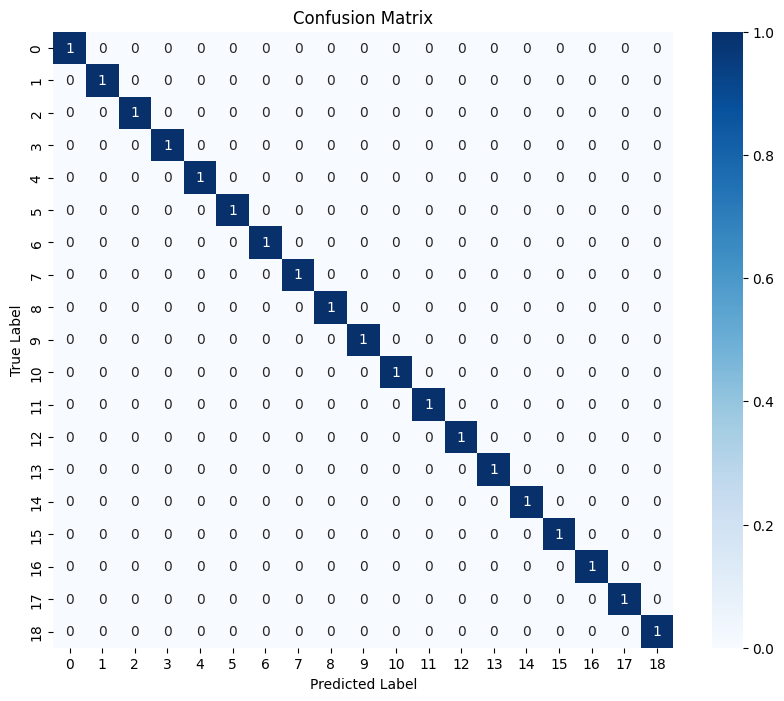

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(gt_labels, pred_labels)
precision = precision_score(gt_labels, pred_labels, average='macro', zero_division=0)
recall = recall_score(gt_labels, pred_labels, average='macro', zero_division=0)
f1 = f1_score(gt_labels, pred_labels, average='macro', zero_division=0)
cm = confusion_matrix(gt_labels, pred_labels)
report = classification_report(gt_labels, pred_labels, zero_division=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [14]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          91       1.00      1.00      1.00         1
          92       1.00      1.00      1.00         1
          93       1.00      1.00      1.00         1
          94       1.00      1.00      1.00         1
          95       1.00      1.00      1.00         1
          96       1.00      1.00      1.00         1
          97       1.00      1.00      1.00         1
          98       1.00      1.00      1.00         1
          99       1.00      1.00      1.00         1
         100       1.00      1.00      1.00         1
         101       1.00      1.00      1.00         1
         102       1.00      1.00      1.00         1
         103       1.00      1.00      1.00         1
         104       1.00      1.00      1.00         1
         105       1.00      1.00      1.00         1
         106       1.00      1.00      1.00         1
         107       1.00      1.00      1.00         1
    